# Chapter 3

# Grokking Deeper: Where did the Date Come From?

## Setting Up
Here, we set up the variables we need from previous chapter's notebook in order to contiinue using them in this chapter. We just need the `clean_data_of_interest` variable to be available.

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv("../datasets/PimaIndiansDiabetes.csv")
data_of_interest = data[["Blood Glucose", "BMI", "Class"]]

bmi_zeros_mask = data_of_interest["BMI"] != 0
bg_zeros_mask = data_of_interest["Blood Glucose"] != 0

clean_data_of_interest = data_of_interest[bmi_zeros_mask & bg_zeros_mask]

clean_data_of_interest.head()

,Blood Glucose,BMI,Class
0,148,33.6,1
1,85,26.6,0
2,183,23.3,1
3,89,28.1,0
4,137,43.1,1


---
## 3.1 Probability and Distributions
Our first step in climbing out of the sample into the population is _normalize_ the count histograms. This is done by weighting the data with $\frac{1}{\text{sample_size}}$, hence treating transforming the counts into _ratios_ that we can interpret as **probabilities**. 

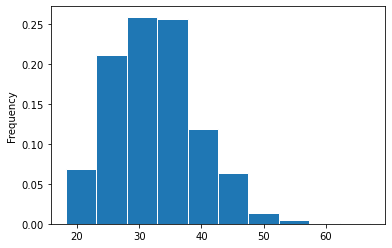

In [7]:
sample_size = clean_data_of_interest.shape[0]
weights_list = [1 / sample_size] * sample_size

clean_data_of_interest["BMI"].plot.hist(weights=weights_list, edgecolor='w')

None

---
Combining this normalization process of counts with the density approach we saw in the previous chapter, we can get a histogram distribution that is _nearly_ free of any ties to the limited sample, a distribution of _**probability density**_. Instead of weighting the data of $\frac{1}{\text{sample_size}\times\text{bin_size}}$ to acheive that, we simply set the `normed` parameter in the `hist()` method to `True` for complete normalization.

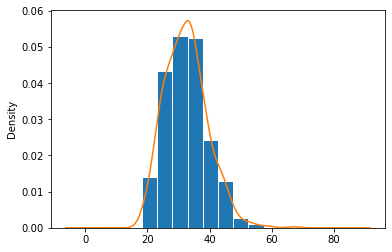

In [19]:
clean_data_of_interest["BMI"].plot.hist(density=True, edgecolor="w") \
.set_ylabel("Probability Density")

clean_data_of_interest["BMI"].plot.kde()

---
## 3.2 Conditional Probability

<h4 style='color:darkred'>Exercise 3.2 </h4>

<span style='color:darkred'>With the definition of both expectation and variance, convince yourself that the following equation is correct and ponder upon what it verbally means: $Var(X) = E[(X - E[X])^2]$</span>

$$ Var(X) = \sum (x - E[X])^2 \cdot f_X(x) $$

<h4 style='color:darkred'>Exercise 3.3 </h4>

<span style='color:darkred'>Using our PIMA Indian diabetes data, try to estimate the conditional probability $P(BG > 140 | Class = 1)$.</span>

In [30]:
# Your solution goes here
N_class_equal_one = clean_data_of_interest.query("Class == 1").shape[0]
N_BG_greater_140 = clean_data_of_interest.query("`Blood Glucose` > 140 and Class == 1").shape[0]

# probability of BG > 140, given that we know that class is 1
N_BG_greater_140 / N_class_equal_one

0.5

count    264.000000
mean     142.488636
std       29.644020
min       78.000000
25%      119.000000
50%      140.500000
75%      167.000000
max      199.000000
Name: Blood Glucose, dtype: float64

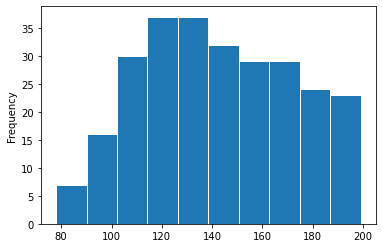

In [35]:
clean_data_of_interest.query("Class == 1")["Blood Glucose"].plot.hist(edgecolor="w")

clean_data_of_interest.query("Class == 1")["Blood Glucose"].describe()

In [36]:
# is P(BG > 140) dependent of Class == 1? Check if P(A|B) = P(A)
N_BG_greater_140 = clean_data_of_interest.query("`Blood Glucose` > 140").shape[0]
N_all_data = clean_data_of_interest.shape[0]

N_BG_greater_140 / N_all_data # is not equal to P(A|B)

0.2553191489361702

---
## 3.3 Applying the Naive Bayes Model with scikit-learn
Before we can apply the naive bayes formula, we need to decide how we're going to model $P(X_1|Y)$ and $P(X_2|Y)$. We can do that by isolating the features for the diabetic records and the non-diabetic records and see how these isolated groups are distributed 

In [3]:
diabetics_mask = clean_data_of_interest["Class"] == 1

diabetics = clean_data_of_interest[diabetics_mask]
non_diabetics = clean_data_of_interest[~diabetics_mask]

Now we can use the `hist()` and `density()` method to see how these data are distributed and how does the approximate PDF looks like

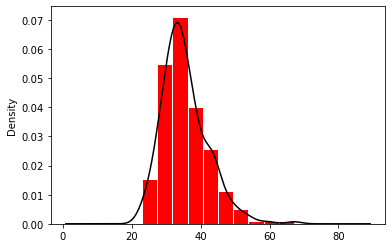

In [4]:
diabetics.loc[:, "BMI"].plot.hist(color='red', density=True, edgecolor="w")
diabetics.loc[:, "BMI"].plot.density(color='black')

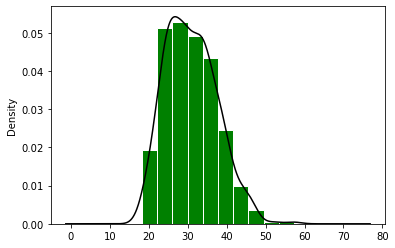

In [5]:
non_diabetics.loc[:, "BMI"].plot.hist(color='green', density=True, edgecolor="w")
non_diabetics.loc[:, "BMI"].plot.density(color='black')

---
<h4 style='color:darkred'>Exercise 3.4 </h4>

<span style='color:darkred'>Verify that the Blood Glucose conditional distribution $X_2|Y$ can be modeled with a normal distribution.</span>

Text(0.5, 0, 'Blood Glucose')

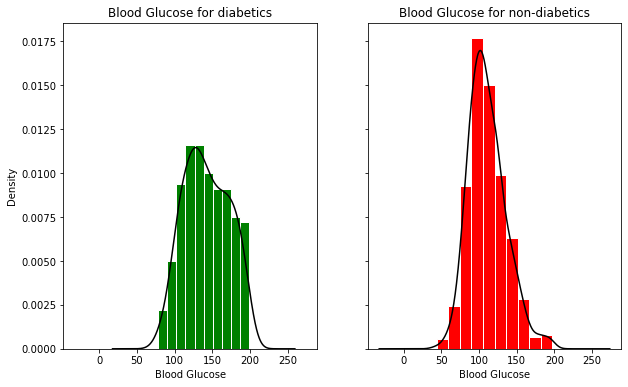

In [6]:
# Your solution goes here
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10,6), sharey=True, sharex=True)

diabetics.loc[:, "Blood Glucose"].plot.hist(color='green', density=True, edgecolor="w", ax=ax[0])
diabetics.loc[:, "Blood Glucose"].plot.density(color='black', ax=ax[0])

non_diabetics.loc[:, "Blood Glucose"].plot.hist(color='red', density=True, edgecolor="w", ax=ax[1])
non_diabetics.loc[:, "Blood Glucose"].plot.density(color='black', ax=ax[1])

ax[0].set_title("Blood Glucose for diabetics")
ax[1].set_title("Blood Glucose for non-diabetics")

ax[0].set_xlabel("Blood Glucose")
ax[1].set_xlabel("Blood Glucose")





---
Now that we know that the conditional distributions $X_1|Y$ and $X_2|Y$ can be modeld with a normal distributions, we're ready to apply our naive Bayes formula. We'll rely here on scikit-learn's `GaussianNB` to do all the parameter estimations for us and use the naive Bayes formula to predict whether a patient is diabetic or not given there BMI and BG measurments. We'll of course first split our data into training and testing set to be able to measure how accurate the naive Bayes model is.

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X = clean_data_of_interest.loc[:, ["Blood Glucose", "BMI"]]
y = clean_data_of_interest.loc[:, "Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

classifier = GaussianNB()
classifier.fit(X_train, y_train)

accuracy = classifier.score(X_test, y_test)
print("Prediction Accuracy: {:.2f}%".format(accuracy * 100))

Prediction Accuracy: 79.79%


---
<h4 style='color:darkred'>Exercise 3.5 </h4>

<span style='color:darkred'>Notice that the data here changed from when we tried out the perceptron model in chapter one, due to the cleaning of missing values that happened in chapter two. Run the perceptron model again as well as the dummy classifier to make the results comparable with what we've got from the naive Bayes model.</span>

In [67]:
# Your solution goes here

# perceptron model
from sklearn.linear_model import Perceptron

classifier = Perceptron()
classifier.fit(X_train, y_train)

accuracy = classifier.score(X_test, y_test)
print("Prediction Accuracy: {:.2f}%".format(accuracy * 100))
# so indeed accuracy went up by removing some outliers/wrong instances

# dummy model
from sklearn.dummy import DummyClassifier

classifier = DummyClassifier()
classifier.fit(X_train, y_train)

accuracy = classifier.score(X_test, y_test)
print("Prediction Accuracy: {:.2f}%".format(accuracy * 100))
# and the performance of the dummy classifier went down

Prediction Accuracy: 43.09%
Prediction Accuracy: 55.32%


---
<h4 style='color:darkred'>Exercise 3.6 </h4>

<span style='color:darkred'>Try to implement the naive Bayes model on the traveling diabetes clinic problem yourself. It'll strengthen your understanding of how the different parts of the model work and how the estimation is done, as well as it'll develop a sense of appreciation of the work done behind scikit-learn and its supporting libraries. To help you in that implementation, note that the Bayes rule doesn't only apply to probabilities, but it also applies on PDF and PMF as well, so you can write the model for our problem as:
.</span>

$$
f_{Y|X_1,X_2}(Y|X_1, X_2) = \frac{f_{X_1|Y}(X_1|Y)f_{X_2|Y}(X_2|Y)f_Y(Y)}{f_{X_1}(X_1)f_{X_2}(X_2)}
$$

In [24]:
# Your solution goes here
from scipy.stats import norm

# parameter estimates
p_y = clean_data_of_interest.query("Class == 1").shape[0] / clean_data_of_interest.shape[0]

mu_x1 = clean_data_of_interest["BMI"].mean()
std_x1 = clean_data_of_interest["BMI"].std()

mu_x2 = clean_data_of_interest["Blood Glucose"].mean()
std_x2 = clean_data_of_interest["Blood Glucose"].std()

mu_x1_given_y_equal_0 = non_diabetics["BMI"].mean()
std_x1_given_y_equal_0 = non_diabetics["BMI"].std()

mu_x1_given_y_equal_1 = diabetics["BMI"].mean()
std_x1_given_y_equal_1 = diabetics["BMI"].std()

mu_x2_given_y_equal_0 = non_diabetics["Blood Glucose"].mean()
std_x2_given_y_equal_0 = non_diabetics["Blood Glucose"].std()

mu_x2_given_y_equal_1 = diabetics["Blood Glucose"].mean()
std_x2_given_y_equal_1 = diabetics["Blood Glucose"].std()

def predict_class(BG, BMI):
    # calc probability for test instance to belong to either class 1 or 0
    p_y0 = (norm.pdf(BMI, loc=mu_x1_given_y_equal_0, scale=std_x1_given_y_equal_0) * norm.pdf(BG, loc=mu_x2_given_y_equal_0, scale=std_x2_given_y_equal_0) * (1 - p_y)) / (norm.pdf(BMI, loc=mu_x1, scale=std_x1) * norm.pdf(BG, loc=mu_x2, scale=std_x2))
    p_y1 = (norm.pdf(BMI, loc=mu_x1_given_y_equal_1, scale=std_x1_given_y_equal_1) * norm.pdf(BG, loc=mu_x2_given_y_equal_1, scale=std_x2_given_y_equal_1) * p_y) / (norm.pdf(BMI, loc=mu_x1, scale=std_x1) * norm.pdf(BG, loc=mu_x2, scale=std_x2))

    return 1 if p_y1 > p_y0 else 0

In [25]:
accuracy = 0
for i, (x1, x2) in X_test.iterrows():
    y_pred = predict_class(x1, x2)
    if y_pred == y_test.loc[i]:
        accuracy += 1

accuracy / X_test.shape[0]

0.7925531914893617